# Lecture 15: 2023-28-03 Vector Semantics

## Overview of lecture

- Finish introduction of Neural Networks
- Introduction to lexical semantics
- Introduction to Vector Semantics
  - Vector semantics: Osgood et al. (1957)
  - Vector semantics: Joos (1950), Harris (1954), Firth (1957)
- Embeddings
    - Word2Vec
    - GloVe
    - FastText
    - ELMo
    - BERT


## Introduction to Neural Networks

<center><img src="./images/Neuron.drawio.png" width="800" height="400" /></center>

* Caculating Loss (measuring error - training a model adjusts weights and biases to minimize loss)
* Optimizing Loss (adjust weights and biases to minimize loss)
* Backpropagation (calculate the gradient of the loss function with respect to the weights and biases)

## Introduction to Lexical Semantics

Taken from Jurafsky and Martin (2023) chapter 23:

```

Lady Bracknell: Are your parents living?
Jack: I have lost both my parents.
Lady Bracknell: To lose one parent, Mr. Worthing, may be regarded as a misfortune; to lose both looks like carelessness.

```

* words are relational units that are prone to messiness and ambiguity
* Ambiguity is a fact of life in language (`mouse` as in a rodent or a computer device)
* Polysemy: a word or lemma with multiple meanings (`bank` as in a river bank or a financial institution)
* `Antonymy`: words (or lemmas) with opposite meanings (`hot` and `cold`)
* `Synonym`: words (or lemmas) that are similar in meaning (`couch` and `sofa`)
* Taxonimic relations
    * `hyponymy` (subordinate): words (or lemmas) that are more specific (`poodle` is a hyponym of `dog`) - subclasses or members
    * `hypernym` (superordinate): words (or lemmas) that are more general (`dog` is a hypernym of `poodle`) - classes
        * entailment: being A entails being B (`dog` entails `poodle`)
        * is-a hierarchy: a hierarchy of classes that is organized by the is-a relation or A IS-A B
    * `meronymy`: words (or lemmas) that are part of a larger entity (`leg` is a meronym of `human`) - part-whole relationships
    * `metonymy`: words (or lemmas) that are associated with a larger entity (`the crown` is a metonym of `the queen`) - association (prototype categories)
    * `holonymy`: words (or lemmas) that are a whole of a smaller entity (`face` is a holonym of `eye`) - whole-part relationships


In [1]:
from nltk.corpus import wordnet as wn

def get_taxonomy(noun):
    synsets = wn.synsets(noun)
    if synsets:
        synset = synsets[0]  # take the first synset
        hypernyms = synset.hypernyms()
        hyponyms = synset.hyponyms()
        meronyms = synset.part_meronyms() + synset.substance_meronyms() + synset.member_holonyms()
        holonyms = synset.part_holonyms() + synset.substance_holonyms() + synset.member_meronyms()
        return {
            "word": synset.name(),
            "definition": synset.definition(),
            "hypernyms": [h.name() for h in hypernyms],
            "hyponyms": [h.name() for h in hyponyms],
            "meronyms": [m.name() for m in meronyms],
            "holonyms": [h.name() for h in holonyms]
        }
    else:
        return None


In [2]:
result = get_taxonomy("dog")
for k,v in result.items():
    print(k, v, sep=":")

word:dog.n.01
definition:a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times; occurs in many breeds
hypernyms:['canine.n.02', 'domestic_animal.n.01']
hyponyms:['basenji.n.01', 'corgi.n.01', 'cur.n.01', 'dalmatian.n.02', 'great_pyrenees.n.01', 'griffon.n.02', 'hunting_dog.n.01', 'lapdog.n.01', 'leonberg.n.01', 'mexican_hairless.n.01', 'newfoundland.n.01', 'pooch.n.01', 'poodle.n.01', 'pug.n.01', 'puppy.n.01', 'spitz.n.01', 'toy_dog.n.01', 'working_dog.n.01']
meronyms:['flag.n.07', 'canis.n.01', 'pack.n.06']
holonyms:[]


In [3]:
from nltk.corpus import wordnet as wn

def get_verb_relations(verb):
    synsets = wn.synsets(verb, pos=wn.VERB)
    if synsets:
        relations = {
            "antonyms": set(),
            "entailments": set(),
            "causes": set(),
            "also_sees": set(),
            "verb_groups": set(),
            "similar_tos": set()
        }
        for synset in synsets:
            for lemma in synset.lemmas():
                antonyms = lemma.antonyms()
                if antonyms:
                    relations["antonyms"].add(antonyms[0].name())
            for entailment in synset.entailments():
                relations["entailments"].add(entailment.name())
            for cause in synset.causes():
                relations["causes"].add(cause.name())
            for also_see in synset.also_sees():
                relations["also_sees"].add(also_see.name())
            for verb_group in synset.verb_groups():
                relations["verb_groups"].add(verb_group.name())
            for similar in synset.similar_tos():
                relations["similar_tos"].add(similar.name())
        return relations
    else:
        return None


In [4]:
result = get_verb_relations("walk")
for k,v in result.items():
    print(k, v, sep=":")

antonyms:{'ride'}
entailments:{'step.v.01'}
causes:set()
also_sees:set()
verb_groups:{'walk.v.08', 'walk.v.05', 'walk.v.02', 'walk.v.01', 'walk.v.04', 'walk.v.09', 'walk.v.03', 'walk.v.10'}
similar_tos:set()


## Distributional Semantics

* Firth (1957) proposed a model of word meaning based on the idea that words are associated with other words in a network of semantic relations.
* Firth (1957), Joos (1950), and Harris (1954) all proposed models of word meaning based on the idea that words are associated with other words in a network of semantic relations. Thus the idea of distributional semantics takes its name from the fact that the meaning of a word is discerned by the words that tend to occur in its company.

> You shall know a word by the company it keeps. (Firth, 1957)

## Word Similarity

* Word similarity is a measure of the degree of semantic similarity between two words. This measure takes into account the distributional properties of words in a corpus. Whereas words like `coffee` would rarely occur in a dictionary entry for the word `cup`, users of language expect that the words `coffee` and `cup` are similar in meaning. They are similar, in this case, because semantic frames are shared between the two words. The semantic frame of `coffee` is a hot beverage, and the semantic frame of `cup` is a container for a hot beverage. The semantic frames of `coffee` and `cup` overlap, and this overlap is the basis for the similarity between the two words. We can capture these similarities by computing the distributional properties of words in a corpus.

## How can we represent words and their meanings in numerical format?

We vectorize it!

We can represent words in a vector space or embedding space.

### Word2Vec, Mikolov et al., 2013

Goal: to create “techniques for measuring the quality of the resulting vector representations, with the expectation that not only will similar words tend to be close to each other, but that words can have multiple degrees of similarity.” (Mikolov, et al., 2013a, 2013b)

Mikolov et al. propose two log-linear solutions

* Continuous Bag-of-Words Model
* Continuous Skip-gram Model 


<img src="./images/mikolov.png" width="900" height="500" />

Word2Vec embeddings are static embeddings, and therefore they do not capture the cooccurrence of words in a sentence. This is a problem for downstream tasks that require contextualized embeddings.

## Glove, Pennington et al., 2014

“...the shallow window-based methods [e.g., log bi-linear models, CBOW, or Skipgram] suffer from the disadvantage that they do not operate directly on the co-occurrence statistics of the corpus. Instead, these models scan context windows across the entire corpus, which fails to take advantage of the vast amount of repetition in the data.” Pennington, et al., 2014.

<center><img src="./images/glove.png" width="800" height="400" /></center>

## FastText, Bojanowski et al., 2017

<center><img src="./images/fasttext.png" width="900" height="500" /></center>

## Elmo, Peters et al., 2018

<center><img src="./images/elmo.png" width="900" height="400" /></center>

"They [embeddings] should ideally model both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy)." ([Peters et al., 2018, p. 1](https://arxiv.org/pdf/1802.05365.pdf))

# How to create word embeddings



Let's code out the word2vec CBOW and Skipgram models and compare them. To do this, let's define our configuration parameters.

In [5]:
import os

# Number of dimensions
EMBEDDING_SIZE = 10

# Window size
WINDOW_SIZE = 5

ITERATIONS = 1000

# OUTPUT
OUTPUT_PATH = "outputs"

## Let's plot the loss for the skipgram model
SKIPGRAM_LOSS = os.path.join(OUTPUT_PATH, 'loss_skipgram')
SKIPGRAM_TSNE = os.path.join(OUTPUT_PATH, 'tsne_skipgram')

## let's plot the loss for the cbow model
CBOW_LOSS = os.path.join(OUTPUT_PATH, 'loss_cbow')
CBOW_TSNE = os.path.join(OUTPUT_PATH, 'tsne_cbow')

In [6]:
# We need to preprocess the textual data

# We can use tensorflow to preprocess the data
import tensorflow as tf

def tokenize_data(data):
    # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/text_to_word_sequence
    tokenized_text = tf.keras.preprocessing.text.text_to_word_sequence(input_text=data)

    vocab = sorted(set(tokenized_text))
    tokenized_text_size = len(tokenized_text)

    return (vocab, tokenized_text_size, tokenized_text)

2023-03-30 13:46:26.848596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 13:46:26.931592: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-30 13:46:26.933443: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-30 13:46:26.933450: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc

## CBOW

In [7]:
# define our imports 
import tensorflow as tf

tf.random.set_seed(42)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

In [8]:
# Load our text
with open("./data/data_nietzsche.txt") as f:
    lines = f.readlines()
    
text_data = "".join(lines)


In [9]:
text_data[:1000]

"\ufeffProject Gutenberg's The Genealogy of Morals, by Friedrich Wilhelm Nietzsche\n\nThis eBook is for the use of anyone anywhere in the United States and most\nother parts of the world at no cost and with almost no restrictions\nwhatsoever.  You may copy it, give it away or re-use it under the terms of\nthe Project Gutenberg License included with this eBook or online at\nwww.gutenberg.org.  If you are not located in the United States, you'll have\nto check the laws of the country where you are located before using this ebook.\n\nTitle: The Genealogy of Morals\n       The Complete Works, Volume Thirteen, edited by Dr. Oscar Levy.\n\nAuthor: Friedrich Wilhelm Nietzsche\n\nEditor: Oscar Levy\n\nTranslator: Horace B. Samuel\n            J. M. Kennedy\n\nRelease Date: June 13, 2016 [EBook #52319]\n\nLanguage: English\n\nCharacter set encoding: UTF-8\n\n*** START OF THIS PROJECT GUTENBERG EBOOK THE GENEALOGY OF MORALS ***\n\n\n\n\nProduced by Marc D'Hooghe at http://www.freeliterature.org\

In [10]:
# Preprocess the data
(vocab, tokenized_text_size, tokenized_text) = tokenize_data(text_data)

In [11]:
# Map our words to indices
vocab_to_index = {
    uniqueWord:index for (index, uniqueWord) in enumerate(vocab)
}

In [12]:
# Create an array of our vocab
index_to_vocab = np.array(vocab)
index_to_vocab

array(["'", "'as", "'better", ..., '––to', '––with', '\ufeffproject'],
      dtype='<U17')

In [13]:
# convert the text to integers
text_as_int = np.array([vocab_to_index[word] for word in tokenized_text])
text_as_int

array([7619, 3064, 6783, ...,  107, 4504, 2091])

In [14]:
# Create a matrix of random data for our context vectors
context_vector_matrix = tf.Variable(
    np.random.rand(tokenized_text_size, EMBEDDING_SIZE)
)
context_vector_matrix[0]

2023-03-30 13:46:41.861981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-30 13:46:41.862477: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-30 13:46:41.862531: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-30 13:46:41.862567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-30 13:46:41.862595: W tensorflow/c

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.39052266, 0.98193063, 0.76471099, 0.90819998, 0.17828442,
       0.45185564, 0.32232513, 0.78582062, 0.19609746, 0.63099603])>

In [15]:
# Create a matrix of random data for our center vectors
center_vector_matrix = tf.Variable(
    np.random.rand(tokenized_text_size, EMBEDDING_SIZE)
)
center_vector_matrix[0]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.59236649, 0.39408658, 0.16578661, 0.54614513, 0.20291647,
       0.37402088, 0.9513441 , 0.78134523, 0.68014413, 0.5964808 ])>

In [16]:
# Define our optimizer

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
optimizer = tf.optimizers.Adam()
loss_list = []

In [17]:
## Compute the vectors for the context and center words
for iter in tqdm(range(ITERATIONS)):
    loss_per_epoch = 0

    for start in range(tokenized_text_size - WINDOW_SIZE):
        indices = text_as_int[start:start + WINDOW_SIZE]

    # https://www.tensorflow.org/api_docs/python/tf/GradientTape
    with tf.GradientTape() as tape:
        combined_context = 0

        # create our context slider
        for count, index in enumerate(indices):
            if count != WINDOW_SIZE // 2:
                combined_context += context_vector_matrix[index, :]
        
        combined_context /= (WINDOW_SIZE - 1)

        # https://www.tensorflow.org/api_docs/python/tf/linalg/matmul
        output = tf.matmul(center_vector_matrix, tf.expand_dims(combined_context, 1))

        # https://www.tensorflow.org/api_docs/python/tf/nn/softmax
        softout = tf.nn.softmax(output, axis=0)
        loss = softout[indices[WINDOW_SIZE // 2]]

        logloss = -tf.math.log(loss)

        loss_per_epoch += logloss.numpy()
        
        # https://www.tensorflow.org/api_docs/python/tf/GradientTape
        grad = tape.gradient(
            logloss, [context_vector_matrix, center_vector_matrix]
        )

        optimizer.apply_gradients(
            zip(grad, [context_vector_matrix, center_vector_matrix])
        )

        loss_list.append(loss_per_epoch)

100%|██████████| 1000/1000 [00:17<00:00, 58.61it/s]


[INFO] Plotting loss ...


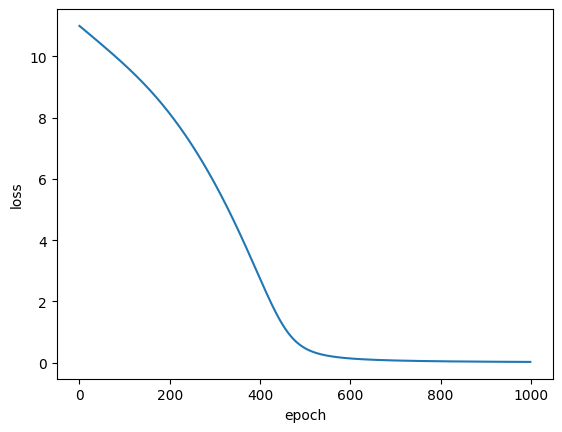

In [18]:
# create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

print("[INFO] Plotting loss ...")
plt.plot(loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig(CBOW_LOSS)

In [19]:
# Convert the embeddings to 2D
tsne_embed = (
    TSNE(n_components=2)
    .fit_transform(center_vector_matrix.numpy())
)
tsne_decode = (
    TSNE(n_components=2)
    .fit_transform(context_vector_matrix.numpy())
)

[INFO] Plotting TSNE embeddings ...


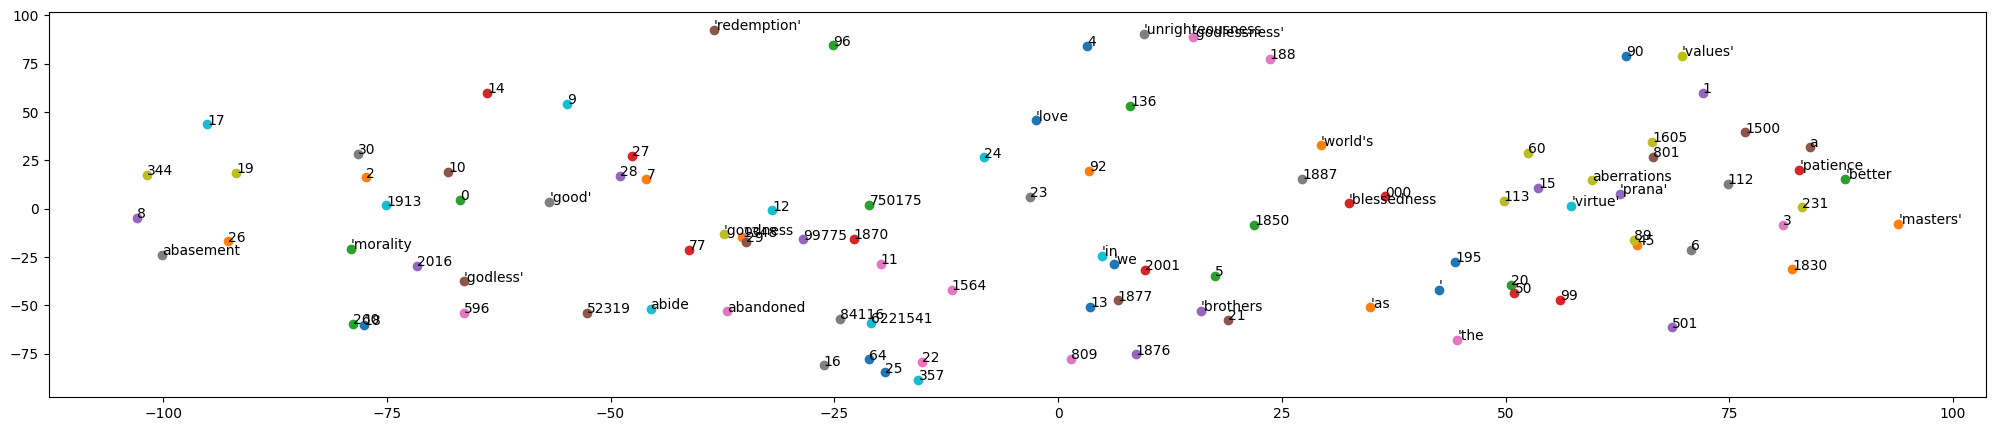

In [20]:
# Plot the embeddings for 100 words
index_count = 0
plt.figure(figsize=(25, 5))

print("[INFO] Plotting TSNE embeddings ...")

for (word, embedding) in tsne_decode[:100]:
    # plot the point in 2d space
    plt.scatter(word, embedding)
    # annotate the point with the word
    plt.annotate(index_to_vocab[index_count], (word, embedding))
    index_count += 1
plt.savefig(CBOW_TSNE)

## SKIPGRAM

In [21]:
## same as above but for skipgram
(vocab, tokenize_text_size, tokenized_text) = tokenize_data(text_data)

vocab_to_index = {
    unique_word:index for (index, unique_word) in enumerate(vocab)
}
index_to_vocab = np.array(vocab)

text_as_int = np.array([vocab_to_index[word] for word in tokenized_text])

context_vector_matrix = tf.Variable(
    np.random.rand(tokenize_text_size, EMBEDDING_SIZE)
)

center_vector_matrix = tf.Variable(
    np.random.rand(tokenize_text_size, EMBEDDING_SIZE)
)

optimizer = tf.optimizers.Adam()
loss_list = []

In [22]:
for iter in tqdm(range(ITERATIONS)):
    loss_per_epoch = 0

    for start in range(tokenize_text_size - WINDOW_SIZE):
        indices = text_as_int[start:start + WINDOW_SIZE]
        
    # https://www.tensorflow.org/api_docs/python/tf/GradientTape
    with tf.GradientTape() as tape:
        
        loss = 0

        center_vector = center_vector_matrix[indices[WINDOW_SIZE // 2], :]
        output = tf.matmul(
            context_vector_matrix, tf.expand_dims(center_vector, 1)
        )

        softmax_output = tf.nn.softmax(output, axis=0)

        for (count, index) in enumerate(indices):
            if count != WINDOW_SIZE // 2:
                loss += softmax_output[index]

            logloss = -tf.math.log(loss)

        loss_per_epoch += logloss.numpy()
        
        # https://www.tensorflow.org/api_docs/python/tf/GradientTape
        grad = tape.gradient(
            logloss, [context_vector_matrix, center_vector_matrix]
        )
        optimizer.apply_gradients(
            zip(grad, [context_vector_matrix, center_vector_matrix])
        )
    loss_list.append(loss_per_epoch)

100%|██████████| 1000/1000 [00:16<00:00, 60.88it/s]


[INFO] plotting loss ...


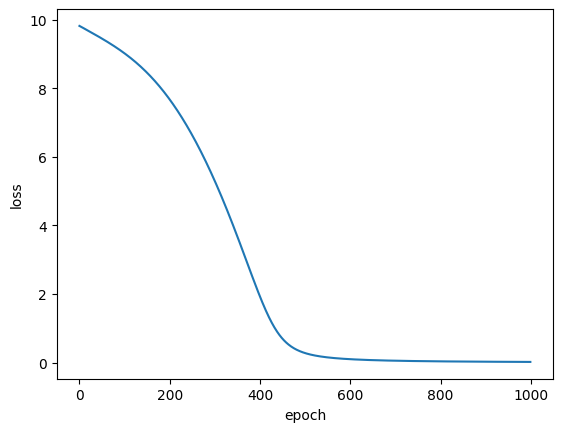

In [23]:
print("[INFO] plotting loss ...")
plt.plot(loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig(SKIPGRAM_LOSS)

In [24]:
# Convert the embeddings to 2D
tsneEmbed = (
    TSNE(n_components=2)
    .fit_transform(center_vector_matrix.numpy())
)
tsneDecode = (
    TSNE(n_components=2)
    .fit_transform(context_vector_matrix.numpy())
)

[INFO] Plotting TSNE Embeddings...


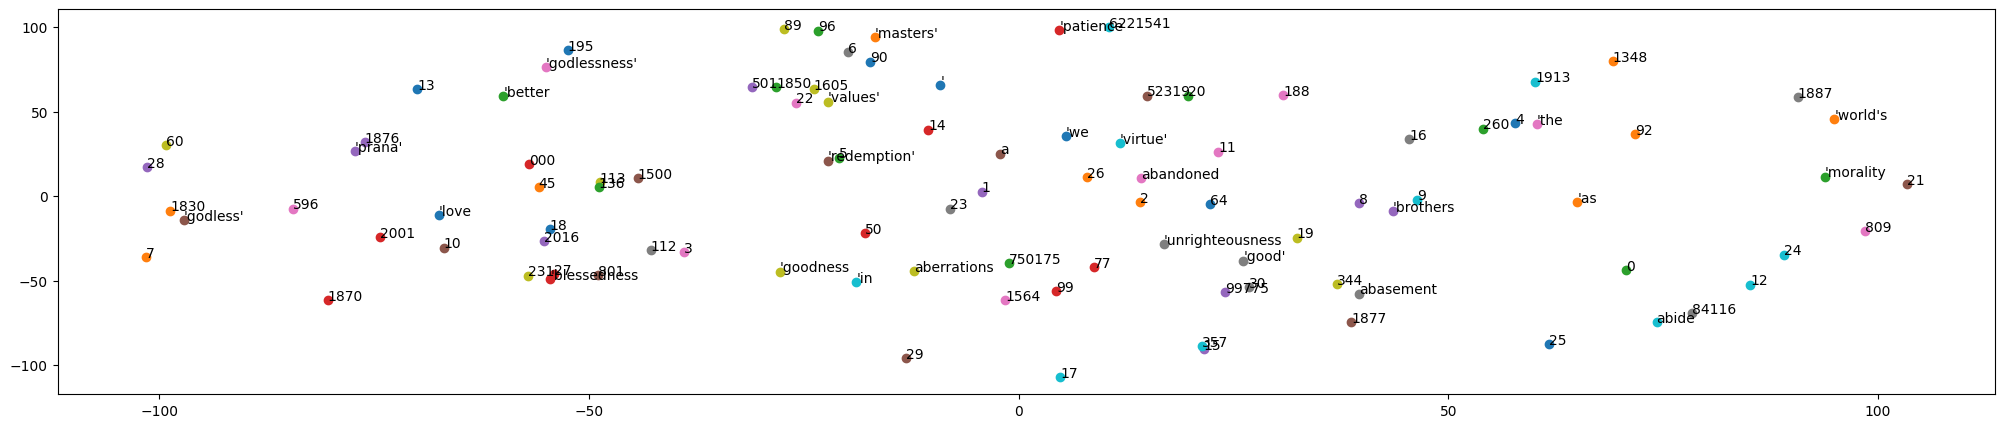

In [28]:
indexCount = 0 

plt.figure(figsize=(25, 5))

print("[INFO] Plotting TSNE Embeddings...")
for (word, embedding) in tsneEmbed[100:200]:
    plt.scatter(word, embedding)
    plt.annotate(index_to_vocab[indexCount], (word, embedding))
    indexCount += 1
plt.savefig(SKIPGRAM_TSNE)

## Tensorboard Embeddings Projector

https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin